# Pennsylvania - initial pre-calibration results

### Libraries

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Colours

In [2]:
dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

### Load the FATES run

In [6]:
fates = '/pscratch/sd/j/jneedham/fates-mrv-runs/runs/fates-MRV-PA-aff-full.Ef14a3cf738-Fb8e4eee5.2024-09-30/run/fates-MRV-PA-aff-full.Ef14a3cf738-Fb8e4eee5.2024-09-30.sofar.nc'
fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time'])/12)
print(nyears)
time = fates.variables['time'] / 365.

tave_start = (nyears*12-20*12)
tave_stop = nyears*12

print(tave_start)
print(tave_stop)

cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)
patch_age_bins = fates.variables['fates_levage'][:]


500
5760
6000


### Biomass and number of plants through time

''

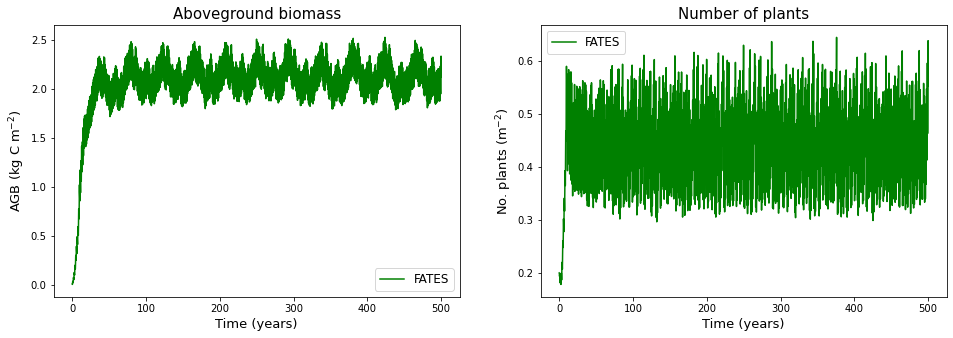

In [4]:
fig1, ((f1ax0, f1ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(16,5))

f1ax0.plot(time, fates.FATES_VEGC_ABOVEGROUND, color='green', label = 'FATES')
f1ax0.set_title(r'Aboveground biomass', fontsize = 15)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 13)
f1ax0.set_xlabel(r'Time (years)', fontsize = 13) 
f1ax0.legend(prop={'size':12})

f1ax1.plot(time, fates.FATES_NPLANT_SZ.sum(dim='fates_levscls'), color='green', label = 'FATES')
f1ax1.set_title(r'Number of plants', fontsize = 15)
f1ax1.set_ylabel(r'No. plants (m$^{-2}$)', fontsize = 13)
f1ax1.set_xlabel(r'Time (years)', fontsize = 13)    
f1ax1.legend(prop={'size':12})
;

### AGB and nplant by size through time

Text(0, 0.5, 'Cohort Size (cm)')

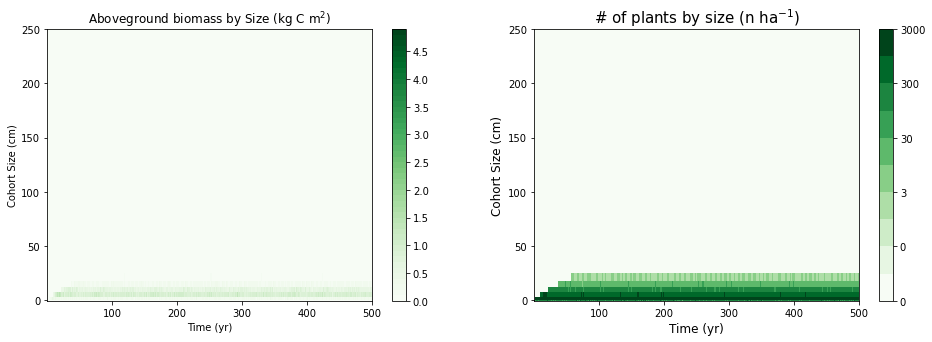

In [5]:
# population numbers as a function of cohort size
NPLANT_SZ = fates.FATES_NPLANT_CANOPY_SZ * 10000

VEGC_ABOVEGROUND_SZ = fates.FATES_VEGC_ABOVEGROUND_SZ

fig2, ((f2ax0, f2ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(16,5))

## set up the first plot: evolution of AGB of plants of a given size
levels = np.arange(0.,5, 0.1)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f2ax0.pcolormesh(time, cohort_size_bins, VEGC_ABOVEGROUND_SZ[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax0)
f2ax0.set_title(r'Aboveground biomass by Size (kg C m$^2$)')
f2ax0.set_xlabel('Time (yr)')
f2ax0.set_ylabel('Cohort Size (cm)')

levels = np.array([0, 0.1,0.3,1.,3.,10.,30., 100., 300., 1000., 3000]) # do a pseudo-log scale here
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f2ax1.pcolormesh(time, cohort_size_bins, (NPLANT_SZ)[:,:,0].transpose(),
                      cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax1)
f2ax1.set_title(r'# of plants by size (n ha$^{-1}$)', fontsize=15)
f2ax1.set_xlabel('Time (yr)', fontsize=12)
f2ax1.set_ylabel('Cohort Size (cm)', fontsize=12)

### Size distributions

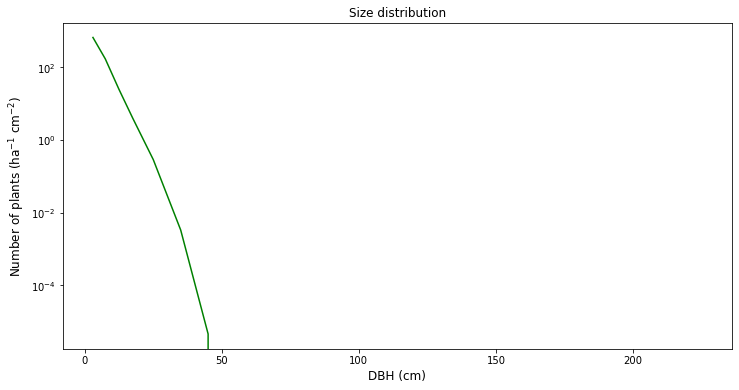

In [8]:
# size bins are LOWER bounds. Remove the fist bin - but add an extra bin to catch trees over last bin edge
cohort_size_bins_ex = np.append(cohort_size_bins[1:], 250)
fates_sizebin_mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2
fates_sizebin_widths = cohort_size_bins_ex[1:] - cohort_size_bins_ex[:-1]

nplant = fates.FATES_NPLANT_SZ.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 10000 # convert to plants per ha (from m-2)
fates_sd = np.squeeze(nplant[1:,])/fates_sizebin_widths


fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f2ax0.plot(fates_sizebin_mids, fates_sd, color='green', label = 'FATES')    
    
f2ax0.set_title(r'Size distribution', fontsize = 12)
f2ax0.set_ylabel(r'Number of plants (ha$^{-1}$ cm$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
f2ax0.set_yscale('log')
#f2ax0.set_xscale('log')

### GPP and NPP

''

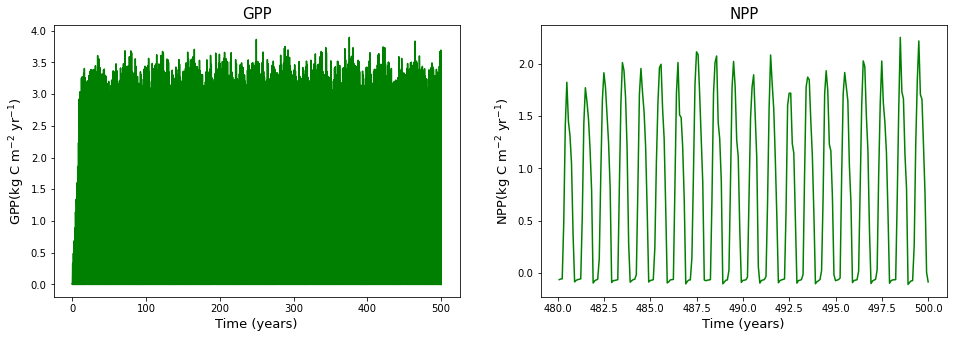

In [16]:
fig1, ((f1ax0, f1ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(16,5))

# convert from per second to per year by multiplying by 365 * 86400
f1ax0.plot(time, fates.FATES_GPP * 365 * 86400, color='green')
f1ax0.set_title(r'GPP', fontsize = 15)
f1ax0.set_ylabel(r'GPP(kg C m$^{-2}$ yr$^{-1}$)', fontsize = 13)
f1ax0.set_xlabel(r'Time (years)', fontsize = 13) 

f1ax1.plot(time[tave_start:tave_stop], fates.FATES_NPP[tave_start:tave_stop] * 365 * 86400, color='green')
f1ax1.set_title(r'NPP', fontsize = 15)
f1ax1.set_ylabel(r'NPP(kg C m$^{-2}$ yr$^{-1}$)', fontsize = 13)
f1ax1.set_xlabel(r'Time (years)', fontsize = 13)    

;

### Growth and mortality 

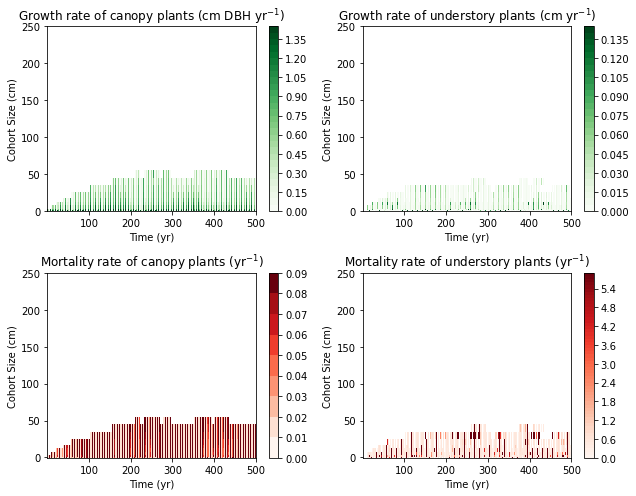

In [10]:
NPLANT_CANOPY_SZ = fates.FATES_NPLANT_CANOPY_SZ 
NPLANT_UNDERSTORY_SZ = fates.FATES_NPLANT_USTORY_SZ

DDBH_CANOPY_SZ = fates.FATES_DDBH_CANOPY_SZ * 100 # convert to cm
DDBH_UNDERSTORY_SZ = fates.FATES_DDBH_USTORY_SZ * 100 # convert to cm

MORT_CANOPY_SZ = fates.FATES_MORTALITY_CANOPY_SZ
MORT_UNDERSTORY_SZ = fates.FATES_MORTALITY_USTORY_SZ

# set up the page
fig3, ((f3ax0, f3ax1), (f3ax2, f3ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

## set up the first plot: growth rate (in diameter increment) in the canopy
levels = np.arange(0.,1.5, 0.05)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax0.pcolormesh(time, cohort_size_bins, np.squeeze(DDBH_CANOPY_SZ / NPLANT_CANOPY_SZ).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax0)
f3ax0.set_title(r'Growth rate of canopy plants (cm DBH yr$^{-1}$)')
f3ax0.set_xlabel('Time (yr)')
f3ax0.set_ylabel('Cohort Size (cm)')

## set up the second plot: growth rate in the understory, units as above
levels = np.arange(0.,0.15, 0.005)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax1.pcolormesh(time, cohort_size_bins, np.squeeze(DDBH_UNDERSTORY_SZ / NPLANT_UNDERSTORY_SZ).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax1)
f3ax1.set_title(r'Growth rate of understory plants (cm yr$^{-1}$)')
f3ax1.set_xlabel('Time (yr)')
f3ax1.set_ylabel('Cohort Size (cm)')

## set up the third plot: mortality rate in the canopy, in units of fraction of trees per year of a given size class and canopy position
levels = np.arange(0.,0.1, 0.01)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax2.pcolormesh(time, cohort_size_bins, np.squeeze(MORT_CANOPY_SZ / NPLANT_CANOPY_SZ).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.set_title(r'Mortality rate of canopy plants (yr$^{-1}$)')
f3ax2.set_xlabel('Time (yr)')
f3ax2.set_ylabel('Cohort Size (cm)')

## set up the fourth plot: mortality rate in the understory, units as above
levels = np.arange(0.,6.0, 0.1)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax3.pcolormesh(time, cohort_size_bins, np.squeeze(MORT_UNDERSTORY_SZ / NPLANT_UNDERSTORY_SZ).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax3)
f3ax3.set_title(r'Mortality rate of understory plants (yr$^{-1}$)')
f3ax3.set_xlabel('Time (yr)')
f3ax3.set_ylabel('Cohort Size (cm)')

fig3.tight_layout()

### LAI and canopy area

''

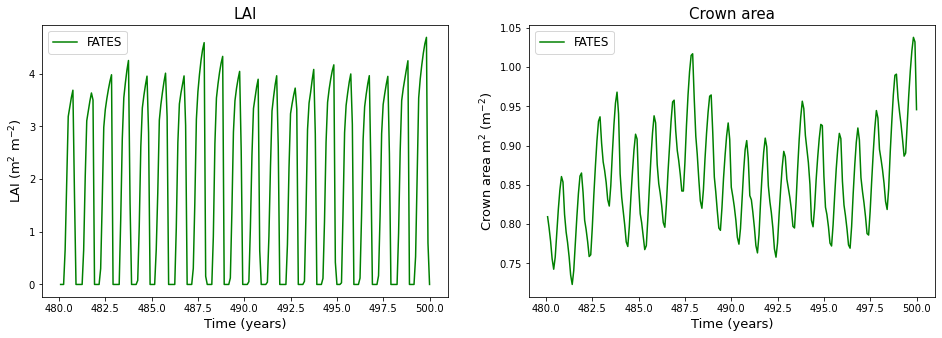

In [15]:
fig1, ((f1ax0, f1ax1)) = plt.subplots(nrows=1,ncols=2, figsize=(16,5))

f1ax0.plot(time[tave_start:tave_stop], fates.FATES_LAI[tave_start:tave_stop], color='green', label = 'FATES')
f1ax0.set_title(r'LAI', fontsize = 15)
f1ax0.set_ylabel(r'LAI (m$^{2}$ m$^{-2}$)', fontsize = 13)
f1ax0.set_xlabel(r'Time (years)', fontsize = 13) 
f1ax0.legend(prop={'size':12})

f1ax1.plot(time[tave_start:tave_stop], fates.FATES_CROWNAREA_PF.sum(dim='fates_levpft')[tave_start:tave_stop], color='green', label = 'FATES')
f1ax1.set_title(r'Crown area', fontsize = 15)
f1ax1.set_ylabel(r'Crown area m$^{2}$ (m$^{-2}$)', fontsize = 13)
f1ax1.set_xlabel(r'Time (years)', fontsize = 13)    
f1ax1.legend(prop={'size':12})
;

### What type of mortality is killing the trees?

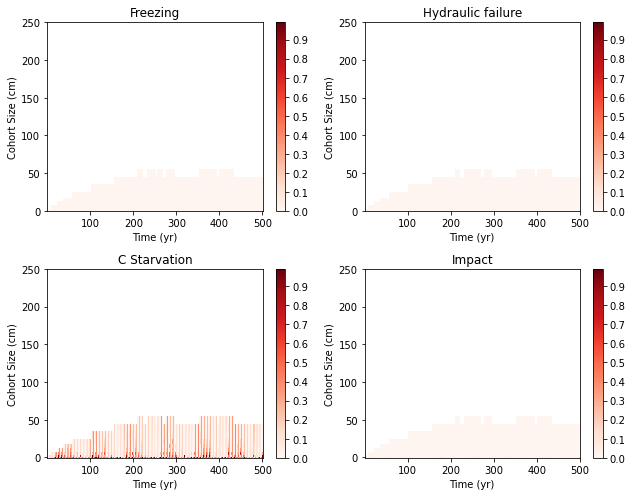

In [18]:
NPLANT_SZ = fates.FATES_NPLANT_SZ 

FREEZING_SZ = fates.FATES_MORTALITY_FREEZING_SZ
TERMINATION_SZ = fates.FATES_MORTALITY_TERMINATION_SZ
IMPACT_SZ = fates.FATES_MORTALITY_IMPACT_SZ
HYDRO_SZ = fates.FATES_MORTALITY_HYDRAULIC_SZ
CSTARV_SZ = fates.FATES_MORTALITY_CSTARV_SZ



# set up the page
fig3, ((f3ax0, f3ax1), (f3ax2, f3ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

## set up the first plot: growth rate (in diameter increment) in the canopy
levels = np.arange(0.,1.0, 0.01)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax0.pcolormesh(time, cohort_size_bins, np.squeeze(FREEZING_SZ / NPLANT_SZ).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax0)
f3ax0.set_title(r'Freezing')
f3ax0.set_xlabel('Time (yr)')
f3ax0.set_ylabel('Cohort Size (cm)')

## set up the second plot: growth rate in the understory, units as above
im = f3ax1.pcolormesh(time, cohort_size_bins, np.squeeze(HYDRO_SZ / NPLANT_SZ).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax1)
f3ax1.set_title(r'Hydraulic failure')
f3ax1.set_xlabel('Time (yr)')
f3ax1.set_ylabel('Cohort Size (cm)')

## set up the third plot: mortality rate in the canopy, in units of fraction of trees per year of a given size class and canopy position
im = f3ax2.pcolormesh(time, cohort_size_bins, np.squeeze(CSTARV_SZ / NPLANT_SZ).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.set_title(r'C Starvation')
f3ax2.set_xlabel('Time (yr)')
f3ax2.set_ylabel('Cohort Size (cm)')

## set up the fourth plot: mortality rate in the understory, units as above
im = f3ax3.pcolormesh(time, cohort_size_bins, np.squeeze(IMPACT_SZ / NPLANT_SZ).transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax3)
f3ax3.set_title(r'Impact')
f3ax3.set_xlabel('Time (yr)')
f3ax3.set_ylabel('Cohort Size (cm)')

fig3.tight_layout()